In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Load dataset

In [2]:
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
list(set(train_data.dtypes.tolist()))

[dtype('float64'), dtype('bool'), dtype('O')]

In [6]:
data_num = train_data.select_dtypes(include=['float64'])
data_num.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


# Data Preprocessing

In [7]:
train_data['Cabin'].str.split('/', expand=True)[1].unique()

array(['0', '1', '2', ..., '1892', '1893', '1894'], dtype=object)

In [8]:
train_preprocessed = train_data.drop(['PassengerId', 'Name'], axis=1)

In [9]:
#  把'Cabin'列拆分成'Deck', 'CabinNumber', 'Side'三列
train_preprocessed[['Deck', 'CabinNumber', 'Side']] = train_preprocessed['Cabin'].str.split('/', expand=True)
train_preprocessed = train_preprocessed.drop('Cabin', axis=1)
print(train_preprocessed.dtypes)
train_preprocessed.head()

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Deck             object
CabinNumber      object
Side             object
dtype: object


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [10]:
# 查看['HomePlanet', 'Destination', 'Deck']有哪些可能的选择
columns = ['HomePlanet', 'Destination', 'Deck']
for column in columns:
    # 提取当前列的数据并去除重复
    unique_data = train_preprocessed[column].drop_duplicates()
    print(unique_data)
    print()

0     Europa
1      Earth
12      Mars
59       NaN
Name: HomePlanet, dtype: object

0       TRAPPIST-1e
5     PSO J318.5-22
9       55 Cancri e
47              NaN
Name: Destination, dtype: object

0         B
1         F
2         A
7         G
15      NaN
21        E
27        D
28        C
1004      T
Name: Deck, dtype: object



**使用 pd.factorize() 函数将当前列的字符串或布尔值转换为数值，并将转换后的结果赋值给原始列。sort=True 参数表示按照字母顺序对不同的字符串值进行编码**

In [11]:
'''
for column in train_preprocessed.columns:：这行代码遍历 train_preprocessed 数据框的所有列。
if train_preprocessed[column].dtype == 'object' or train_preprocessed[column].dtype == 'bool':：这个条件语句检查当前列的数据类型是否为字符串 (object) 或布尔型 (bool)。如果是，则执行下面的代码块。
train_preprocessed[column] = pd.factorize(train_preprocessed[column], sort=True)[0]：这行代码使用 pd.factorize() 函数将当前列的字符串或布尔值转换为数值，并将转换后的结果赋值给原始列。sort=True 参数表示按照字母顺序对不同的字符串值进行编码。
'''
index = {} # 创建一个空字典用于存储编码
for column in train_preprocessed.columns:
    if train_preprocessed[column].dtype == 'object' or train_preprocessed[column].dtype == 'bool':
        train_preprocessed[column], index[column] = pd.factorize(train_preprocessed[column], sort=True)
        train_preprocessed[column].replace(-1, np.nan, inplace=True)
# 格式化输出index字典
for key, value in index.items():
    print(f"{key}: {value}")
train_preprocessed.head()

HomePlanet: Index(['Earth', 'Europa', 'Mars'], dtype='object')
CryoSleep: Index([False, True], dtype='bool')
Destination: Index(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype='object')
VIP: Index([False, True], dtype='bool')
Transported: Index([False, True], dtype='bool')
Deck: Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype='object')
CabinNumber: Index(['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005',
       ...
       '990', '991', '992', '993', '994', '995', '996', '997', '998', '999'],
      dtype='object', length=1817)
Side: Index(['P', 'S'], dtype='object')


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,5.0,0.0,1.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0.0,1.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0.0,1.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,5.0,1.0,1.0


In [12]:
train_preprocessed.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
count,8492.000000,8476.000000,8511.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8494.000000,8494.000000,8494.000000
mean,0.665214,0.358306,1.483492,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,4.305392,947.115022,0.504827
std,0.798155,0.479531,0.820237,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,1.778233,504.452654,0.500006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,508.250000,0.000000
50%,0.000000,0.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,1000.000000,1.000000
75%,1.000000,1.000000,2.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,6.000000,1335.000000,1.000000
max,2.000000,1.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,7.000000,1816.000000,1.000000


In [13]:
train_preprocessed.isnull()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8689,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8690,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8691,False,False,False,False,False,False,False,False,False,False,False,False,False,False


To handle the missing data, I opted not to drop any observations and instead chose to impute the missing values in the following features: HomePlanet, Destination, Age, Deck, CabinNumber, and Side. I decided to replace the NaN values in these features with their respective modes. While this approach may not be ideal as it introduces some level of imputation, it allows us to preserve more information from the dataset. Given that the number of NaN values is relatively small, it is unlikely to have a significant negative impact on the results. This approach strikes a balance between addressing missing data and leveraging the available information to derive meaningful insights.

为了处理缺失的数据，原作者选择不删除任何观测值，而是选择在以下特征中估算缺失值：HomePlanet、Destination、Age、Deck、CabinNumber 和 Side。原作者决定将这些功能中的 NaN 值替换为各自的**众数**。虽然这种方法可能并不理想，因为它引入了某种程度的插补，但它允许我们从数据集中保留更多信息。鉴于 NaN 值的数量相对较少，不太可能对结果产生显着的负面影响。这种方法在解决缺失数据和利用可用信息获得有意义的见解之间取得了平衡。

In [14]:
columns_to_impute = ['HomePlanet', 'Destination', 'Age', 'Deck', 'CabinNumber', 'Side']
train_preprocessed[columns_to_impute] = train_preprocessed[columns_to_impute].fillna(train_preprocessed[columns_to_impute].mode().iloc[0])
train_preprocessed.isnull().sum() # 结果表明其他列中还有一些NaN值

HomePlanet        0
CryoSleep       217
Destination       0
Age               0
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Deck              0
CabinNumber       0
Side              0
dtype: int64

In [15]:
train_preprocessed.fillna(0, inplace=True) # 其他值用0填充
train_preprocessed.isnull().sum() # 数据中已无NaN值

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
CabinNumber     0
Side            0
dtype: int64

# Visualize dataset

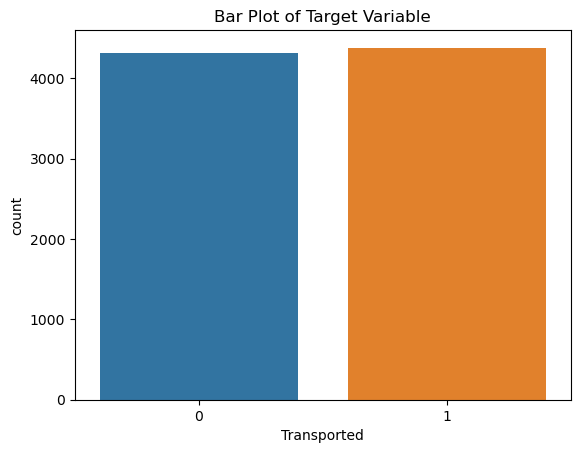

In [16]:
sns.countplot(data=train_preprocessed, x='Transported')
plt.title('Bar Plot of Target Variable')
plt.show()

In [17]:
train_preprocessed.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,5.0,0.0,1.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0.0,1.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0.0,1.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,5.0,1.0,1.0


Text(0.5, 0.98, 'Distribution of Binary Features')

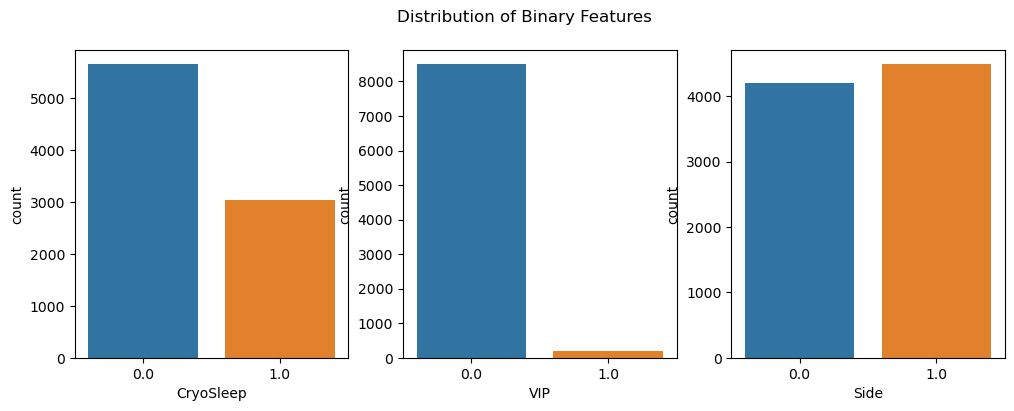

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for idx, feature in enumerate(['CryoSleep', 'VIP', 'Side']):
    sns.countplot(x=feature, data=train_preprocessed, ax=axes[idx])
    
fig.suptitle('Distribution of Binary Features')

In [19]:
data_num = train_preprocessed.select_dtypes(include=['float64'])
data_num.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,5.0,0.0,1.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,1.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,1.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,5.0,1.0,1.0


array([[<Axes: title={'center': 'HomePlanet'}>,
        <Axes: title={'center': 'Destination'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>,
        <Axes: title={'center': 'ShoppingMall'}>],
       [<Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>,
        <Axes: title={'center': 'Transported'}>],
       [<Axes: title={'center': 'Deck'}>,
        <Axes: title={'center': 'CabinNumber'}>, <Axes: >]], dtype=object)

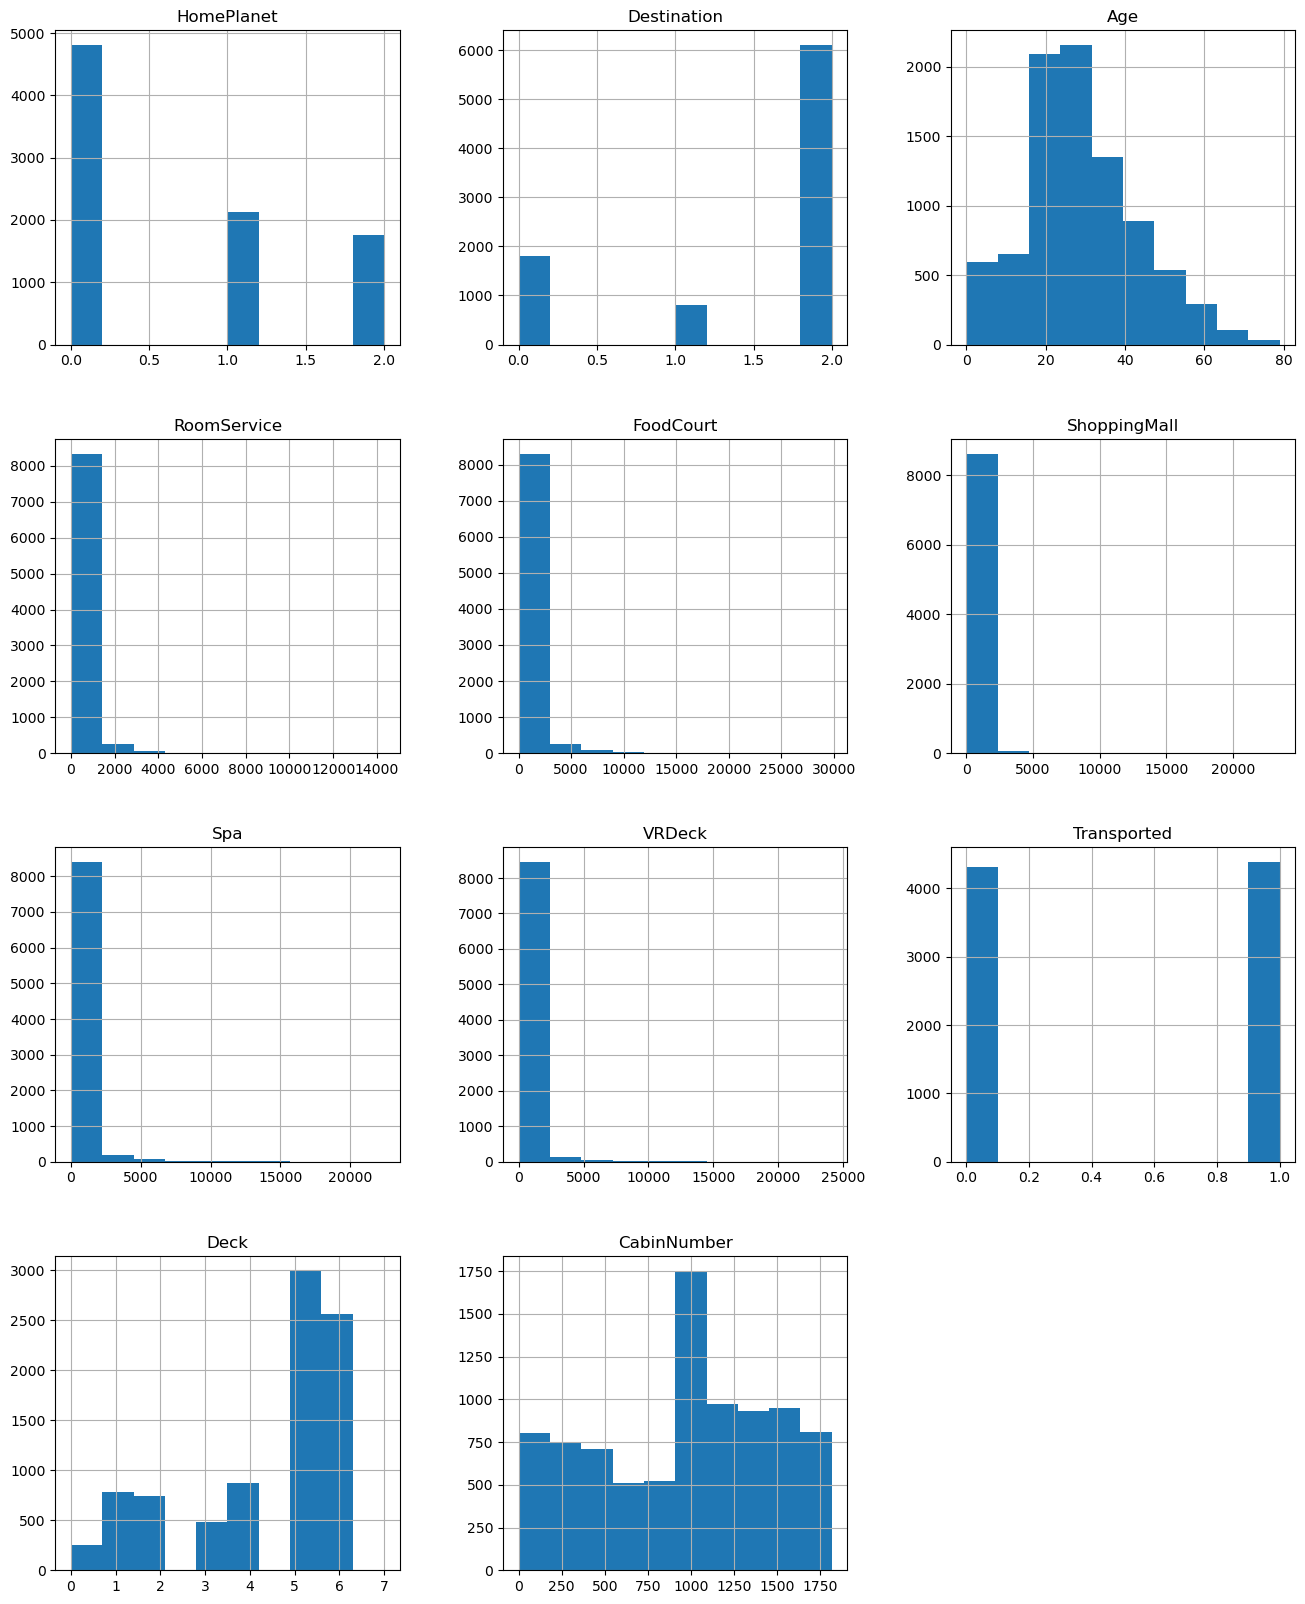

In [20]:
columns_to_exclude = ['CryoSleep', 'VIP', 'Side']
data_num = train_preprocessed.drop(columns=columns_to_exclude)
data_num.hist(figsize=(16, 20))

用的pd.factorize()函数,sort=True 参数表示按照字母顺序对不同的字符串值进行编码，例如A~0, B~2

In [21]:
# 查看['HomePlanet', 'Destination', 'Deck']三列编码的映射关系
for column in ['HomePlanet', 'Destination', 'Deck']:
    if column in index:
        values = index[column]
        mapping = {value: idx for idx, value in enumerate(values)}
        print(f"{column}:")
        for key, value in mapping.items():
            print(f"{key} --> {value}")
        print()

HomePlanet:
Earth --> 0
Europa --> 1
Mars --> 2

Destination:
55 Cancri e --> 0
PSO J318.5-22 --> 1
TRAPPIST-1e --> 2

Deck:
A --> 0
B --> 1
C --> 2
D --> 3
E --> 4
F --> 5
G --> 6
T --> 7



Text(0.5, 0.98, 'Distribution of Categorical Features')

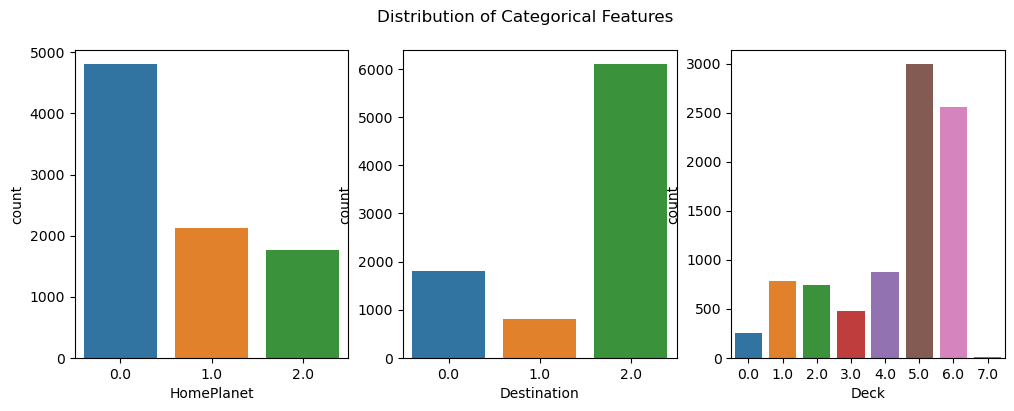

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for idx, feature in enumerate(['HomePlanet', 'Destination', 'Deck']):
    sns.countplot(x=feature, data=train_preprocessed, ax=axes[idx])
fig.suptitle('Distribution of Categorical Features')

Text(0.5, 0.98, 'Distribution of Continuous Features')

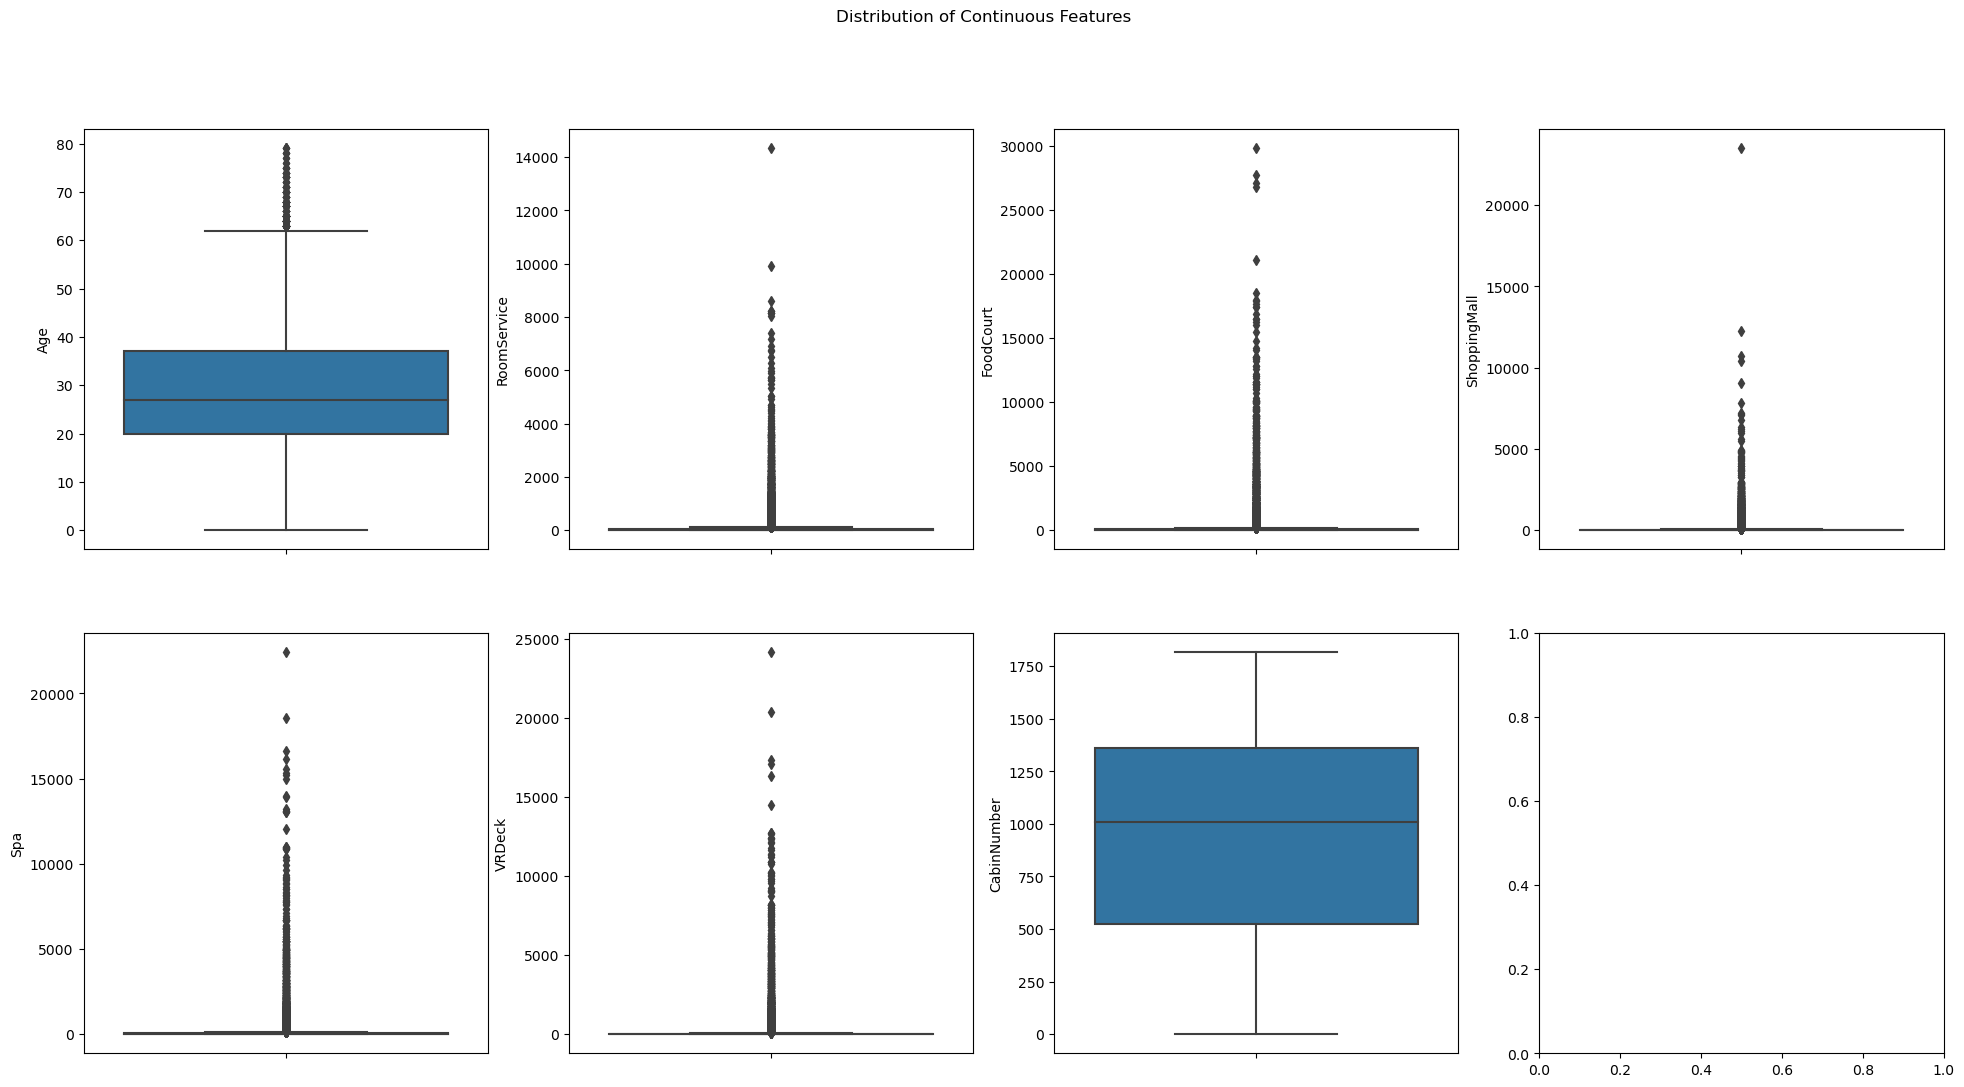

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for idx, feature in enumerate(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
                              'Spa', 'VRDeck', 'CabinNumber']):
    sns.boxplot(y=feature, data=train_preprocessed, ax=axes[idx // 4, idx % 4])

fig.suptitle('Distribution of Continuous Features')

Text(0.5, 0.98, 'Distribution of Continuous Features')

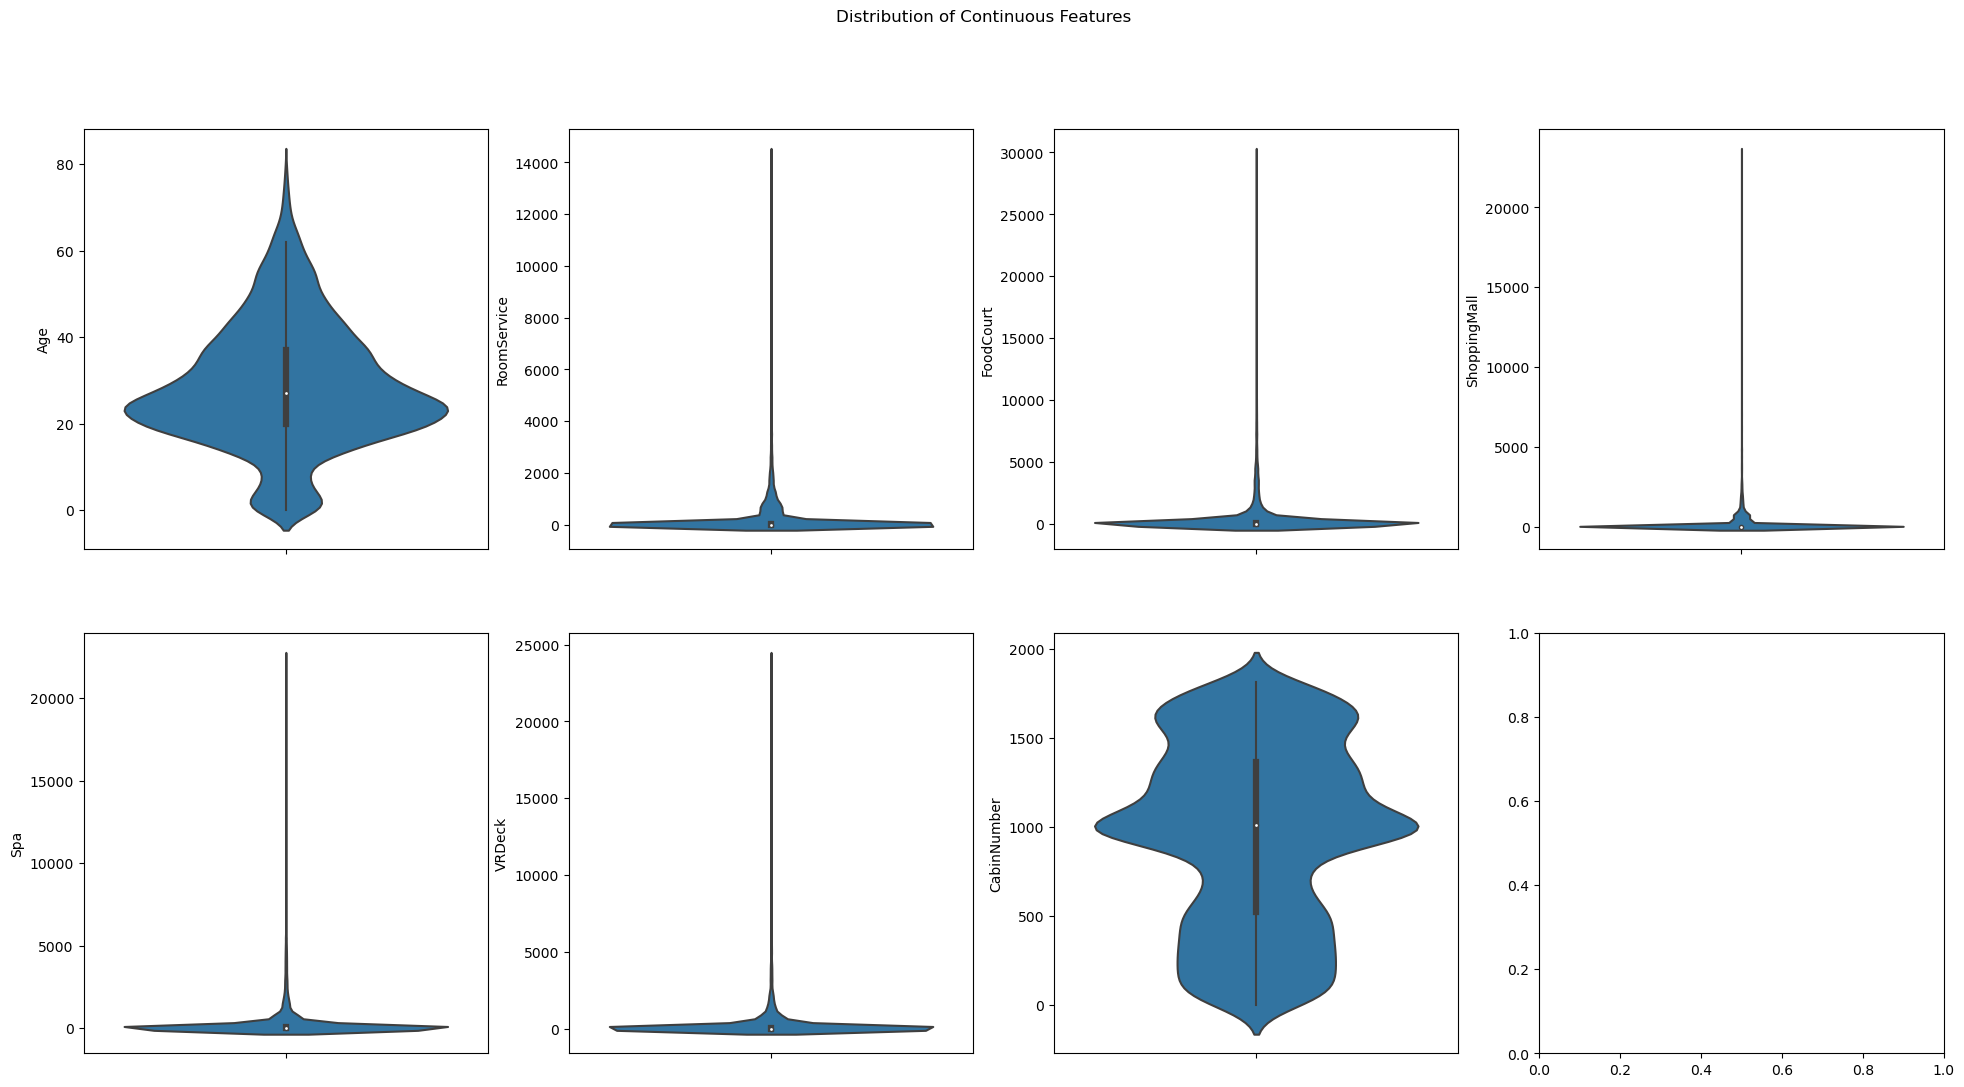

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for idx, feature in enumerate(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
                              'Spa', 'VRDeck', 'CabinNumber']):
    sns.violinplot(y=feature, data=train_preprocessed, ax=axes[idx // 4, idx % 4])

fig.suptitle('Distribution of Continuous Features')

Text(0.5, 0.98, 'Distribution of Continuous Features')

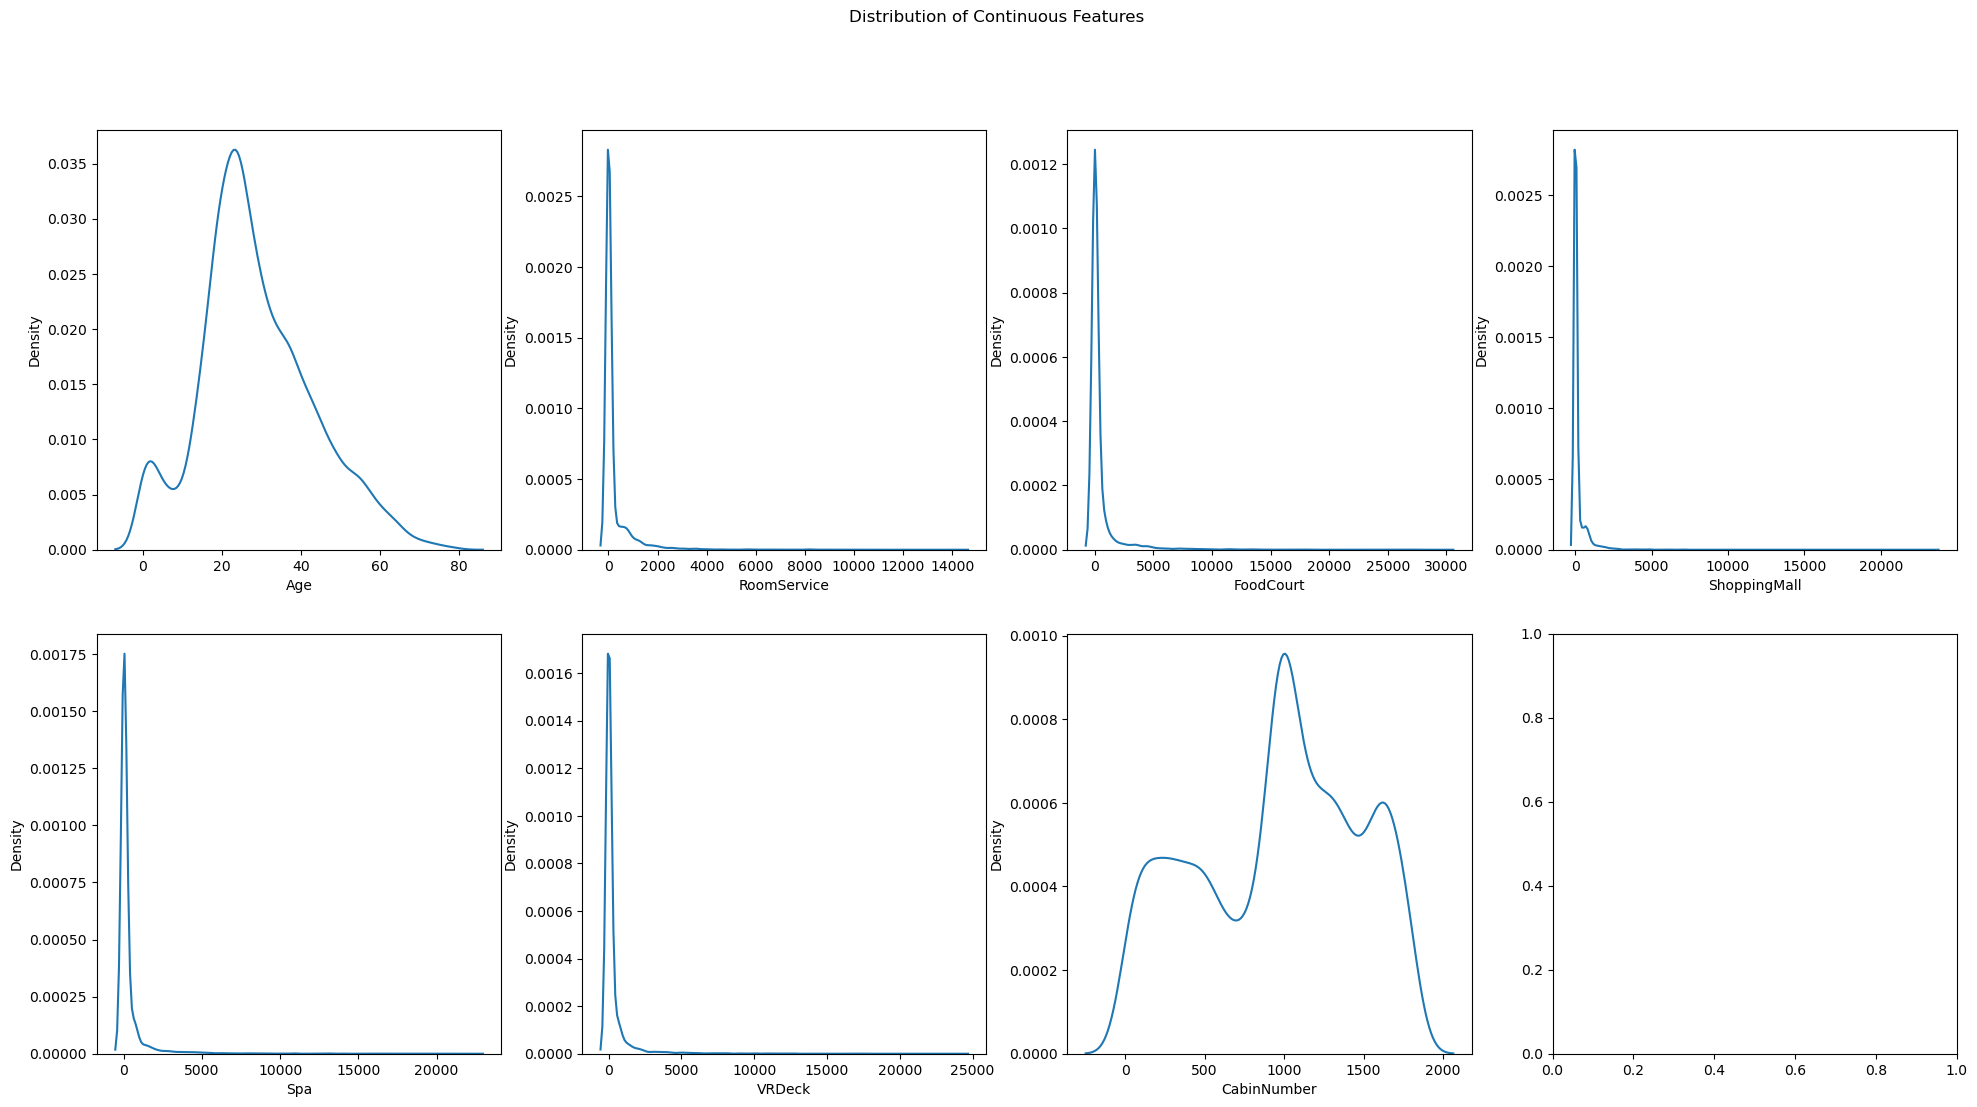

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for idx, feature in enumerate(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
                              'Spa', 'VRDeck', 'CabinNumber']):
    sns.kdeplot(data=train_preprocessed[feature], ax=axes[idx // 4, idx % 4])

fig.suptitle('Distribution of Continuous Features')


# Correlation analysis 相关性分析

Text(0.5, 1.0, 'Correlation of Features')

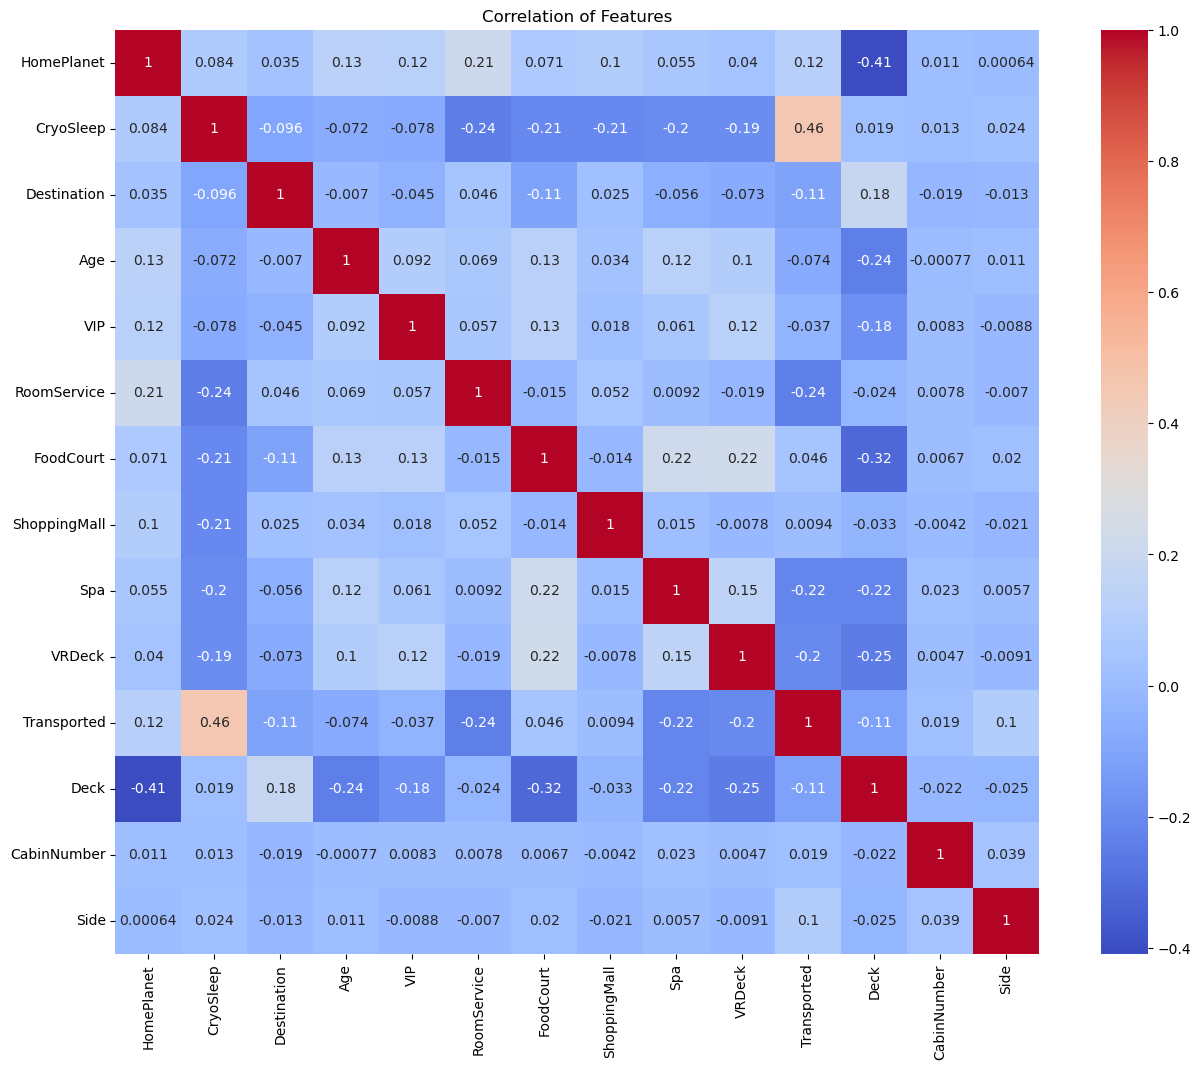

In [26]:
plt.figure(figsize=(16, 12))
sns.heatmap(train_preprocessed.corr(), annot=True, cmap='coolwarm', square=True)

plt.title('Correlation of Features')

In [27]:
features = train_preprocessed.drop('Transported', axis=1)
target = train_preprocessed['Transported']
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.1, random_state=1)

In [28]:
xgb_classifier = xgb.XGBClassifier(eval_metric='logloss')
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [29]:
y_pred = xgb_classifier.predict(X_val)
accuracy_score(y_val, y_pred)

0.8149425287356322

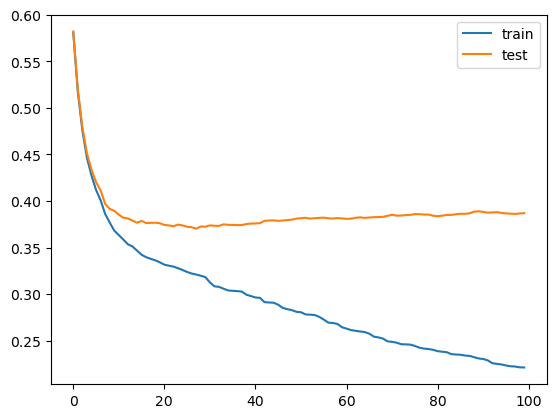

In [30]:
results = xgb_classifier.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()

调整 XGBoost 分类器的一些默认参数，以试图防止过度拟合并提高模型的泛化能力
- n_estimators：指定了要构建的树的数量，即迭代次数。在这里，设置为125。
* max_depth：决定了每棵树的最大深度。它控制了模型的复杂度和拟合能力。在这里，设置为3。
* eta：也称为学习率（learning rate），控制了每一步迭代的权重更新程度。较小的学习率可以使模型更加稳定，但可能需要更多的迭代次数才能收敛到最优解。在这里，设置为0.1。
* reg_alpha和reg_lambda：分别是L1正则化（Lasso）和L2正则化（Ridge）的权重参数。它们可以用来控制模型的复杂度，并防止过拟合。在这里，设置为0.05。
* eval_metric：评估指标，用于衡量模型的性能。在这里，选择了'logloss'作为评估指标。

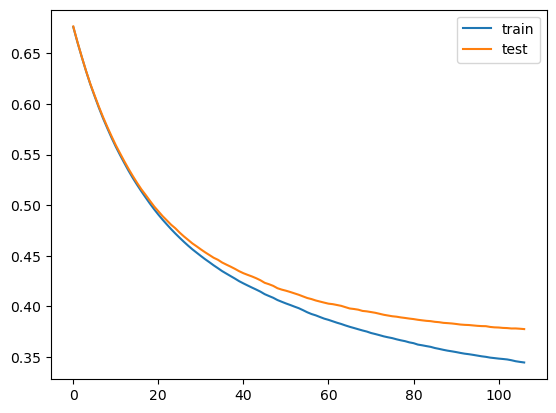

In [31]:
######## my version ##########
xgb_classifier_modified = xgb.XGBClassifier(n_estimators=107, max_depth=6, eta=0.039, reg_alpha=0.02, reg_lambda=0.006, eval_metric='logloss')
xgb_classifier_modified.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
results = xgb_classifier_modified.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()

In [32]:
y_pred = xgb_classifier_modified.predict(X_val)
accuracy_score(y_val, y_pred)

0.8310344827586207

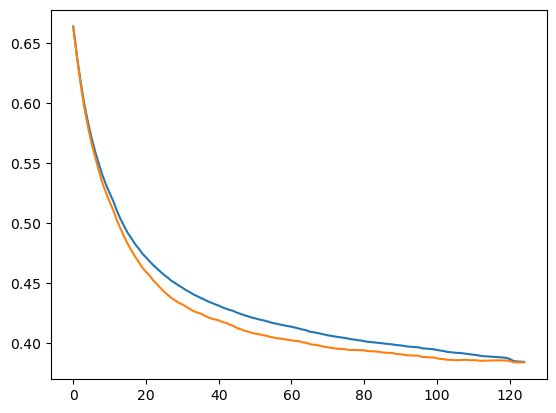

In [33]:
xgb_classifier_modified = xgb.XGBClassifier(n_estimators=125, max_depth=3, eta=0.1, reg_alpha=0.05, reg_lambda=0.05, eval_metric='logloss')
xgb_classifier_modified.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
results = xgb_classifier_modified.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')

In [34]:
y_pred = xgb_classifier_modified.predict(X_val)
accuracy_score(y_val, y_pred)

0.8218390804597702

# optuna 调参

![16880326998361688032645090.png](https://fastly.jsdelivr.net/gh/Chenjiangwen/ImageHostingService@main/pic/16880326998361688032645090.png)

In [35]:
# import optuna
# from optuna.samplers import TPESampler
# from sklearn.metrics import accuracy_score

# # 设置 Optuna 日志级别为 WARNING
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# def objective(trial):
#     params = {
#     'n_estimators': trial.suggest_int('n_estimators', low=80, high=150),
#     'max_depth': trial.suggest_int('max_depth', low=2, high=7),
#     'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.0),
#     'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 0.1),
#     'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 0.1),
#     'eval_metric': 'logloss'
# }

#     xgb_classifier = xgb.XGBClassifier(**params)
#     xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    
#     y_pred = xgb_classifier.predict(X_val)
    
#     return accuracy_score(y_val, y_pred)

# sampler = TPESampler(seed=1)
# study = optuna.create_study(direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# print("Best trial: ", study.best_trial.params)


In [36]:
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
passenger_ids = test_data['PassengerId']
test_preprocessed = test_data.drop(['PassengerId', 'Name'], axis=1)

test_preprocessed[['Deck', 'CabinNumber', 'Side']] = test_data['Cabin'].str.split('/', expand=True)
test_preprocessed = test_preprocessed.drop('Cabin', axis=1)

for column in test_preprocessed.columns:
    if test_preprocessed[column].dtype == 'object' or test_preprocessed[column].dtype == 'bool':
        test_preprocessed[column] = pd.factorize(test_preprocessed[column], sort=True)[0]
        test_preprocessed[column].replace(-1, np.nan, inplace=True)
test_preprocessed[columns_to_impute] = test_preprocessed[columns_to_impute].fillna(train_preprocessed[columns_to_impute].median())
test_preprocessed.fillna(0, inplace=True)

In [37]:
y_test_pred = xgb_classifier_modified.predict(test_preprocessed)
submission = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': y_test_pred.astype(bool)})
submission.to_csv('/kaggle/working/submission.csv', index=False)